In [170]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys

import matplotlib.pyplot as plt
%matplotlib inline

# path to stylegan encoder locally
sys.path.insert(1, '/home/bobby/APhotoADay/data/stylegan-encoder')

import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

# path to puzer's age direction
puzer_age_direction = np.load("puzer_age_direction.npy")

from IPython.display import Markdown, display

In [171]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [172]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

ValueError: Variable learnable_dlatents already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/bobby/APhotoADay/data/stylegan-encoder/encoder/generator_model.py", line 15, in create_variable_for_generator
    initializer=tf.initializers.random_normal())
  File "/home/bobby/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 406, in <listcomp>
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]
  File "/home/bobby/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 406, in run
    in_expr = [input_builder(name) for input_builder, name in zip(custom_inputs, self.input_names)]
  File "/home/bobby/APhotoADay/data/stylegan-encoder/encoder/generator_model.py", line 27, in __init__
    structure='fixed')
  File "<ipython-input-3-5b8e6e491508>", line 7, in <module>
    generator = Generator(Gs_network, batch_size=1, randomize_noise=False)


In [ ]:
# Receive input

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

real_data_path = "real_data" # input("Enter path for real data: ")
real_latent_path = "real_latent" # input("Enter path for real latent: ")
num_of_vid = input("Enter video number: ")
start_age = int(input("Enter start age (days): "))
end_age = int(input("Enter end age (days): "))
averaging_ratio = int(input("Enter averaging ratio (# photos per batch): "))
num_dimensions = int(input("Enter npy dimensions [0-default]: "))
method = int(input("Choose interpolator [0-standard, 1-puzer]: ")) % 2

experiment = "video" + num_of_vid + "_plot_" + str(start_age) + "_to_" + str(end_age) + "_batch=" + str(averaging_ratio) + "_dimensions=" + ("default" if (num_dimensions == 0) else str(num_dimensions)) + "_method=" + ("standard" if (method == 0) else "puzer")
printmd("\n\n**Running experiment: " + experiment + "**", color="blue")

if not os.path.exists("Results/" + experiment):
    os.mkdir("Results/" + experiment)

In [183]:
def findInterpolator(start, end):

    def interpolator(coefficient):
        return ((end - start) * coefficient) + start

    return interpolator

In [184]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [185]:
def findError(real, interpolator):
    line = interpolator(1) - interpolator(0)
    
    normalizedLine = line * (1/np.linalg.norm(line))
    
    distanceLine = interpolator(0) - real - (np.dot((interpolator(0) - real), normalizedLine) * normalizedLine)
    
    return real + distanceLine, np.linalg.norm(distanceLine)

In [186]:
def average(vectors):
    return sum(vectors)/len(vectors)

In [187]:
def reduceDimension(matrix, dimensionsToLeave):
    
    shape = matrix.shape
    
    if (dimensionsToLeave == 0):
        return matrix, np.zeros(shape)
    
    matrix = matrix.flatten()
    
    aux = matrix
    
    for i in range(0, dimensionsToLeave * 512):
        aux[i] = 0
    
    return np.reshape(matrix - aux, shape), np.reshape(aux, shape)

def restoreDimension (matrix, truncated):
    return matrix + truncated

In [188]:
# Create fake npy's and csv file

fake_latent_path = "fake_latent" # input("Enter path for fake latent: ")

if not os.path.exists(fake_latent_path):
    os.mkdir(fake_latent_path)

csv_file = "Results/" + experiment + "/" + experiment + ".csv"

real_latent_dir = os.listdir(real_latent_path)
files = sorted(real_latent_dir, key=lambda x: int(os.path.splitext(x)[0]))

start_age_npy, aux= reduceDimension (np.load(real_latent_path + "/" + str(start_age) + ".npy"), num_dimensions)
end_age_npy, aux = reduceDimension (np.load(real_latent_path + "/" + str(end_age) + ".npy"), num_dimensions)

if method == 0: # standard
    interpolator = findInterpolator(start_age_npy.flatten(), end_age_npy.flatten())
else:
    interpolator = findInterpolator(start_age_npy.flatten(), (start_age_npy + puzer_age_direction).flatten())

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    #if averaging_ratio == 1:
    #    for real_npy in files:
    #        shape = np.load(real_latent_path + "/" + real_npy).shape   
    #        fake_npy, MSE = findError(np.load(real_latent_path + "/" + real_npy).flatten(), interpolator, num_dimensions) # real should be latent
    #        fake_npy_aux = np.reshape(fake_npy, shape)
    #        np.save(fake_latent_path + "/" + real_npy, fake_npy_aux)
    #        writer.writerow([real_npy[:-4], MSE])
            
    if averaging_ratio >= 1:
        vectors_left = len(files)
        batch = []
        batch_average_age = 0
        
        for real_npy in files:
            
            if (len(batch) < averaging_ratio and vectors_left > 0):
                batch.append(np.load(real_latent_path + "/" + real_npy).flatten())
                batch_average_age += int(real_npy[:-4])
                vectors_left -= 1
                continue
                
            batch_average_age /= len(batch)
            shape = np.load(real_latent_path + "/" + real_npy).shape
            batch_aux, batch_truncated = reduceDimension(average(batch), num_dimensions)
            fake_npy, MSE = findError(batch_aux.flatten(), interpolator)
            fake_npy_aux = np.reshape(fake_npy, shape)
            np.save(fake_latent_path + "/" + str(int(batch_average_age)) + ".npy", fake_npy_aux + np.reshape(batch_truncated, shape))
            writer.writerow([str(batch_average_age), MSE])
            
            batch = []
            batch_average_age = 0

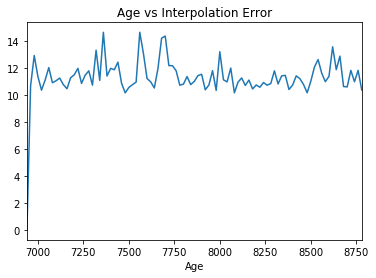

In [189]:
# Display and save plot

data = pd.read_csv(csv_file).set_index('Age')
data_plot = data.plot(title = "Age vs Interpolation Error", legend = None)

data_plot.get_figure().savefig("Results/" + experiment + "/" + experiment + ".png")

In [190]:
def generate_image(latent_vector, size):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((size, size))

def show(latent_vector):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    ax[i].imshow(generate_image(latent_vector))
    ax[i].set_title(latent_vector)
    [x.axis('off') for x in ax]
    plt.show()

In [191]:
# Decode fakes

fake_data_path = "fake_data" # input("Enter path for fake data: ")

if not os.path.exists(fake_data_path):
    os.mkdir(fake_data_path)

for file in os.listdir(fake_latent_path):
    img = generate_image(np.load(fake_latent_path + "/" + file), 1024)
    img.save(fake_data_path + "/" + file[:-4] + ".png")

In [148]:
# Create videos

from distutils.dir_util import copy_tree
import shutil

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

# Real video

shutil.copytree("real_data", "real_temp")
# shutil.copytree(real_data_path, "real_temp")
num_reals = len(next(os.walk("real_temp"))[2])

os.chdir("/home/bobby/APhotoADay/True_vs_Learned/real_temp")

os.system("python3 ../rename3.py . 0")
os.system("ffmpeg -f image2 -framerate 25 -pattern_type sequence -start_number 0 -r " + str(num_reals / 6) 
          + " -i %d.png -vcodec libx264 -acodec aac real_broken.mp4")
os.system("ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4")

shutil.copy('real.mp4', "/home/bobby/APhotoADay/True_vs_Learned/Results/" + experiment)

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")
shutil.rmtree("/home/bobby/APhotoADay/True_vs_Learned/real_temp")

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

# Fake video

shutil.copytree("fake_data", "fake_temp")
# shutil.copytree(fake_data_path, "fake_temp")
num_fakes = len(next(os.walk("fake_temp"))[2])

os.chdir("/home/bobby/APhotoADay/True_vs_Learned/fake_temp")

os.system("python3 ../rename3.py . 0")
os.system("ffmpeg -f image2 -framerate 25 -pattern_type sequence -start_number 0 -r " + str(num_fakes / 6) 
          + " -i %d.png -vcodec libx264 -acodec aac fake_broken.mp4")
os.system("ffmpeg -i fake_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p fake.mp4")

shutil.copy('fake.mp4', "/home/bobby/APhotoADay/True_vs_Learned/Results/" + experiment)

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")
shutil.rmtree("/home/bobby/APhotoADay/True_vs_Learned/fake_temp")

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

In [102]:
printmd("\n\n**Experiment " + experiment + " successfully finished**", color="green")

<span style='color:green'>

**Experiment video1_plot_6940_to_8740_batch=10_dimensions=default_method=standard successfully finished**</span>